# Aprendizaje

In [11]:
import numpy as np
import torch

* Crear un algoritmo que _aprende_ de la data
* Hacer un _fit_ a la data
* El proceso: Una funcion con un numero de parametros desconocidos cuyos valores son estimados de la data
* Un modelo

Pytorch esta diseniado para faciliatar la creacion de modelos para los cuales las derivadas del error con respecto a los parametros pueden ser expresadas de forma analitica.

## El aprendizaje es la estimacion de parametros

* Data
* Escoger un modelo
* Estimar los parametros del modelo para tener buenas predicciones sobre data nueva.

## El problema

Tenemos un termometro que no ensenia las unidades en las cuales muestra la temperatura.

* data: lecturas del termometro y los valores correspondientes en una unidad conocida.
* Escoger un modelo
* Ajustar los parametros iterativamente hasta ue la medida del error sea lo suficientemente baja

In [12]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # Temperatura en grados celsios
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # Unidades desconocidas
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

### Escogiendo nuestro primer modelo

t_c = w * t_u + b

**Spoiler**: Sabemos que un modelo linear es el modelo correcto.

* Tenemos un modelo con parametros desconocidos: $w$ y $b$
* Tenemos que estimar esos parametros para que el error entre $\hat{y}$ y $y$ sea lo mas pequenio posible
* Todavia no hemos definido una medida de ese error.
    * Esta medida, _loss function_, deberia ser alta si el error es alto e idealmente deberia ser lo mas bajo posible cuando haya un match perfecto.
* Nuestro proceso de optimizacion deberia encontrar $w$ y $b$ para que el _loss function_ este en un minimo.

### Loss function

* Una funcion que calcula un valor numerico que el proceso de optimizacion va a intentar minimizar.
* El calculo del _loss_ normalmente involucra tomar la diferencia entre el output deseado para alguna muestra de entrenamiento y el verdadero output producido por el modelo cuando ve esos outputs.
* En nuestro caso: `t_p - t_c`
* Nuestra _loss_function_ deberia siempre ser positiva
* Conceptualmente un _loss function_ es una forma de priorizar cuales errores de nuestro training sample arreglar, para que los ajustes a los parametros resulten en ajustes a los outputs para las muestras con mayor peso.


Ejemplos:
* $|t_p - t_c|$
* $(t_p - t_c)^2$

## Problema a PyTorch

In [13]:
def model(t_u, w, b):
    return w * t_u + b


def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [14]:
w = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [15]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

## La gradiente

**Como estimamos $w$ y $b$ para que el _loss_ llegue al minimo?**

* _Gradient descent_
    * Calcular la razon de cambio del _loss_ con respecto a cada parametro
    * Aplicar un cambio a cada parametro en la direccion que reduzca el _loss_

In [16]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) -
                        loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

**Conceptualmente:** 
* Un incremento unitario en $w$ va a provocar un cambio en el _loss_. 
    * Si el cambio es negativo, tenemos que incrementar $w$ para minimizar el _loss_
    * Si el cambio es positivo, tenemos que reducir $w$
    
**Por cuanto debemos de incrementar o reducir el valor de $w$?**
* Proporcional a la razon de cambio del _loss_

In [17]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [18]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) -
                        loss_fn(model(t_u, w, b - delta), t_c) / (2.0 * delta))

b = b - learning_rate * loss_rate_of_change_b

**Esto representa un paso en gradient descent**

## Version analitica

* Que pasa si el valor de delta fuera infinitesimamente pequenio?
* La derivada del _loss_ con respecto a cada parametro.
    * $\frac{\partial L}{\partial w} = \frac{\partial L}{\partial t_p} \frac{\partial t_p}{\partial w}$

In [19]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

$\frac{\partial x^2}{\partial x} = 2x$

In [20]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

In [21]:
def model(t_u, w, b):
    return w * t_u + b


def dmodel_dw(t_u, w, b):
    return t_u


def dmodel_db(t_u, w, b):
    return 1.0

La funcion retornando la gradiente del _loss_ con respecto a $w$ y $b$

In [22]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_p, t_c) * dmodel_dw(t_u, w, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.mean(), dloss_db.mean()])

## Training loop

Ya tenemos todo para optimizar nuestros parametros:
* Empezamos con un valor tentativo para cada paremetro
* Actualizamos iterativamente
* Paramos despues de un numero fijo de iteraciones
* o hasta que $w$ y $b$ dejen de cambiar


**Epoch**: una iteracion de entrenamiento durante la cual actualizamos los parametros para todo nuestro dataset de entrenamiento

In [23]:
def training_loop(model, n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        t_p = model(t_u, w, b) # Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # Backward pass
        
        params = params - learning_rate * grad
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss {loss}")
            if print_params:
                print(f"\tParams: {params}")
                print(f"\tGrad: {grad}")
        
    return params

In [24]:
training_loop(model,
              n_epochs = 100,
              learning_rate= 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 1763.8846435546875
	Params: tensor([-44.1730,  -0.8260])
	Grad: tensor([4517.2964,   82.6000])
Epoch 10, Loss 9.090107547845813e+34
	Params: tensor([3.2144e+17, 5.6621e+15])
	Grad: tensor([-3.2700e+19, -5.7600e+17])
Epoch 20, Loss inf
	Params: tensor([1.3457e+35, 2.3704e+33])
	Grad: tensor([-1.3690e+37, -2.4114e+35])
Epoch 30, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 40, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 50, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 60, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 70, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 80, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 90, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])
Epoch 100, Loss nan
	Params: tensor([nan, nan])
	Grad: tensor([nan, nan])


tensor([nan, nan])

### Que paso?

* Como podemos limitar la magnitud de `learning_rate * grad`?

In [25]:
training_loop(model,
              n_epochs = 100,
              learning_rate= 1e-4,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 1763.8846435546875
	Params: tensor([ 0.5483, -0.0083])
	Grad: tensor([4517.2964,   82.6000])
Epoch 10, Loss 29.105241775512695
	Params: tensor([ 0.2324, -0.0166])
	Grad: tensor([1.4803, 3.0544])
Epoch 20, Loss 29.095884323120117
	Params: tensor([ 0.2323, -0.0196])
	Grad: tensor([-0.0531,  3.0268])
Epoch 30, Loss 29.08671760559082
	Params: tensor([ 0.2323, -0.0226])
	Grad: tensor([-0.0533,  3.0263])
Epoch 40, Loss 29.077558517456055
	Params: tensor([ 0.2324, -0.0256])
	Grad: tensor([-0.0533,  3.0258])
Epoch 50, Loss 29.068401336669922
	Params: tensor([ 0.2325, -0.0287])
	Grad: tensor([-0.0532,  3.0252])
Epoch 60, Loss 29.05925178527832
	Params: tensor([ 0.2325, -0.0317])
	Grad: tensor([-0.0533,  3.0247])
Epoch 70, Loss 29.050098419189453
	Params: tensor([ 0.2326, -0.0347])
	Grad: tensor([-0.0532,  3.0242])
Epoch 80, Loss 29.04095458984375
	Params: tensor([ 0.2326, -0.0377])
	Grad: tensor([-0.0532,  3.0236])
Epoch 90, Loss 29.03180503845215
	Params: tensor([ 0.2327, -0.0408

tensor([ 0.2327, -0.0438])

### Mejor

El comportamiento se mantuvo estable

Hay otro problema:
* la gradiente

```
Epoch 1, Loss 1763.8846435546875
	Params: tensor([ 0.5483, -0.0083])
	Grad: tensor([4517.2964,   82.6000])
```

In [26]:
4517.2964/82.6000

54.68881840193705

In [27]:
t_un = 0.1 * t_u

In [28]:
training_loop(model,
              n_epochs = 100,
              learning_rate= 1e-2,
              params = torch.tensor([1.0, 0.0]),
              t_u = t_un, # normalizado
              t_c = t_c)

Epoch 1, Loss 80.36434173583984
	Params: tensor([1.7761, 0.1064])
	Grad: tensor([-77.6140, -10.6400])
Epoch 10, Loss 29.030487060546875
	Params: tensor([ 2.3232, -0.0710])
	Grad: tensor([-0.5355,  2.9295])
Epoch 20, Loss 28.157800674438477
	Params: tensor([ 2.3746, -0.3615])
	Grad: tensor([-0.5093,  2.8832])
Epoch 30, Loss 27.314294815063477
	Params: tensor([ 2.4251, -0.6471])
	Grad: tensor([-0.5007,  2.8346])
Epoch 40, Loss 26.498987197875977
	Params: tensor([ 2.4747, -0.9280])
	Grad: tensor([-0.4923,  2.7868])
Epoch 50, Loss 25.710935592651367
	Params: tensor([ 2.5235, -1.2040])
	Grad: tensor([-0.4840,  2.7398])
Epoch 60, Loss 24.949237823486328
	Params: tensor([ 2.5714, -1.4755])
	Grad: tensor([-0.4758,  2.6936])
Epoch 70, Loss 24.212995529174805
	Params: tensor([ 2.6186, -1.7423])
	Grad: tensor([-0.4678,  2.6482])
Epoch 80, Loss 23.501379013061523
	Params: tensor([ 2.6649, -2.0047])
	Grad: tensor([-0.4599,  2.6035])
Epoch 90, Loss 22.813547134399414
	Params: tensor([ 2.7105, -2.262

tensor([ 2.7553, -2.5162])

In [29]:
params = training_loop(model,
                       n_epochs = 5000,
                       learning_rate= 1e-2,
                       params = torch.tensor([1.0, 0.0]),
                       t_u = t_un,
                       t_c = t_c,
                       print_params=False)

params

Epoch 1, Loss 80.36434173583984
Epoch 10, Loss 29.030487060546875
Epoch 20, Loss 28.157800674438477
Epoch 30, Loss 27.314294815063477
Epoch 40, Loss 26.498987197875977
Epoch 50, Loss 25.710935592651367
Epoch 60, Loss 24.949237823486328
Epoch 70, Loss 24.212995529174805
Epoch 80, Loss 23.501379013061523
Epoch 90, Loss 22.813547134399414
Epoch 100, Loss 22.148710250854492
Epoch 110, Loss 21.506103515625
Epoch 120, Loss 20.88498306274414
Epoch 130, Loss 20.284622192382812
Epoch 140, Loss 19.70433807373047
Epoch 150, Loss 19.14344596862793
Epoch 160, Loss 18.6013126373291
Epoch 170, Loss 18.077299118041992
Epoch 180, Loss 17.57081413269043
Epoch 190, Loss 17.081254959106445
Epoch 200, Loss 16.608064651489258
Epoch 210, Loss 16.150693893432617
Epoch 220, Loss 15.708612442016602
Epoch 230, Loss 15.281317710876465
Epoch 240, Loss 14.868304252624512
Epoch 250, Loss 14.469095230102539
Epoch 260, Loss 14.083236694335938
Epoch 270, Loss 13.710277557373047
Epoch 280, Loss 13.349786758422852
Epoch 

Epoch 2350, Loss 2.9367880821228027
Epoch 2360, Loss 2.9364817142486572
Epoch 2370, Loss 2.936187505722046
Epoch 2380, Loss 2.935900926589966
Epoch 2390, Loss 2.9356260299682617
Epoch 2400, Loss 2.935356855392456
Epoch 2410, Loss 2.9350991249084473
Epoch 2420, Loss 2.934852361679077
Epoch 2430, Loss 2.9346094131469727
Epoch 2440, Loss 2.9343771934509277
Epoch 2450, Loss 2.9341509342193604
Epoch 2460, Loss 2.9339349269866943
Epoch 2470, Loss 2.933722734451294
Epoch 2480, Loss 2.933521270751953
Epoch 2490, Loss 2.9333252906799316
Epoch 2500, Loss 2.933133840560913
Epoch 2510, Loss 2.932952880859375
Epoch 2520, Loss 2.9327738285064697
Epoch 2530, Loss 2.932602882385254
Epoch 2540, Loss 2.9324381351470947
Epoch 2550, Loss 2.9322776794433594
Epoch 2560, Loss 2.932121992111206
Epoch 2570, Loss 2.9319722652435303
Epoch 2580, Loss 2.931828260421753
Epoch 2590, Loss 2.9316866397857666
Epoch 2600, Loss 2.931553840637207
Epoch 2610, Loss 2.931422472000122
Epoch 2620, Loss 2.931295871734619
Epoch 

Epoch 4790, Loss 2.927647590637207
Epoch 4800, Loss 2.9276483058929443
Epoch 4810, Loss 2.9276480674743652
Epoch 4820, Loss 2.9276480674743652
Epoch 4830, Loss 2.9276468753814697
Epoch 4840, Loss 2.9276468753814697
Epoch 4850, Loss 2.927647352218628
Epoch 4860, Loss 2.9276487827301025
Epoch 4870, Loss 2.9276483058929443
Epoch 4880, Loss 2.9276483058929443
Epoch 4890, Loss 2.9276480674743652
Epoch 4900, Loss 2.9276480674743652
Epoch 4910, Loss 2.927647590637207
Epoch 4920, Loss 2.927647590637207
Epoch 4930, Loss 2.927647590637207
Epoch 4940, Loss 2.9276463985443115
Epoch 4950, Loss 2.9276483058929443
Epoch 4960, Loss 2.9276468753814697
Epoch 4970, Loss 2.9276480674743652
Epoch 4980, Loss 2.9276466369628906
Epoch 4990, Loss 2.9276483058929443
Epoch 5000, Loss 2.927647590637207


tensor([  5.3671, -17.3012])

* El _loss_ disminuyo mientras fuimos actualizando los parametros en la direccion de _gradient descent_
* No llego a cero
    * Porque?
    
* Sin embargo, los valores de $w$ y $b$ quedaron bastante cerca a los valores necesarios para convertir a Celsius a Fahrenheit.
* Los valores exactos son:
    * $w=5.5556$
    * $b=-17.7778$

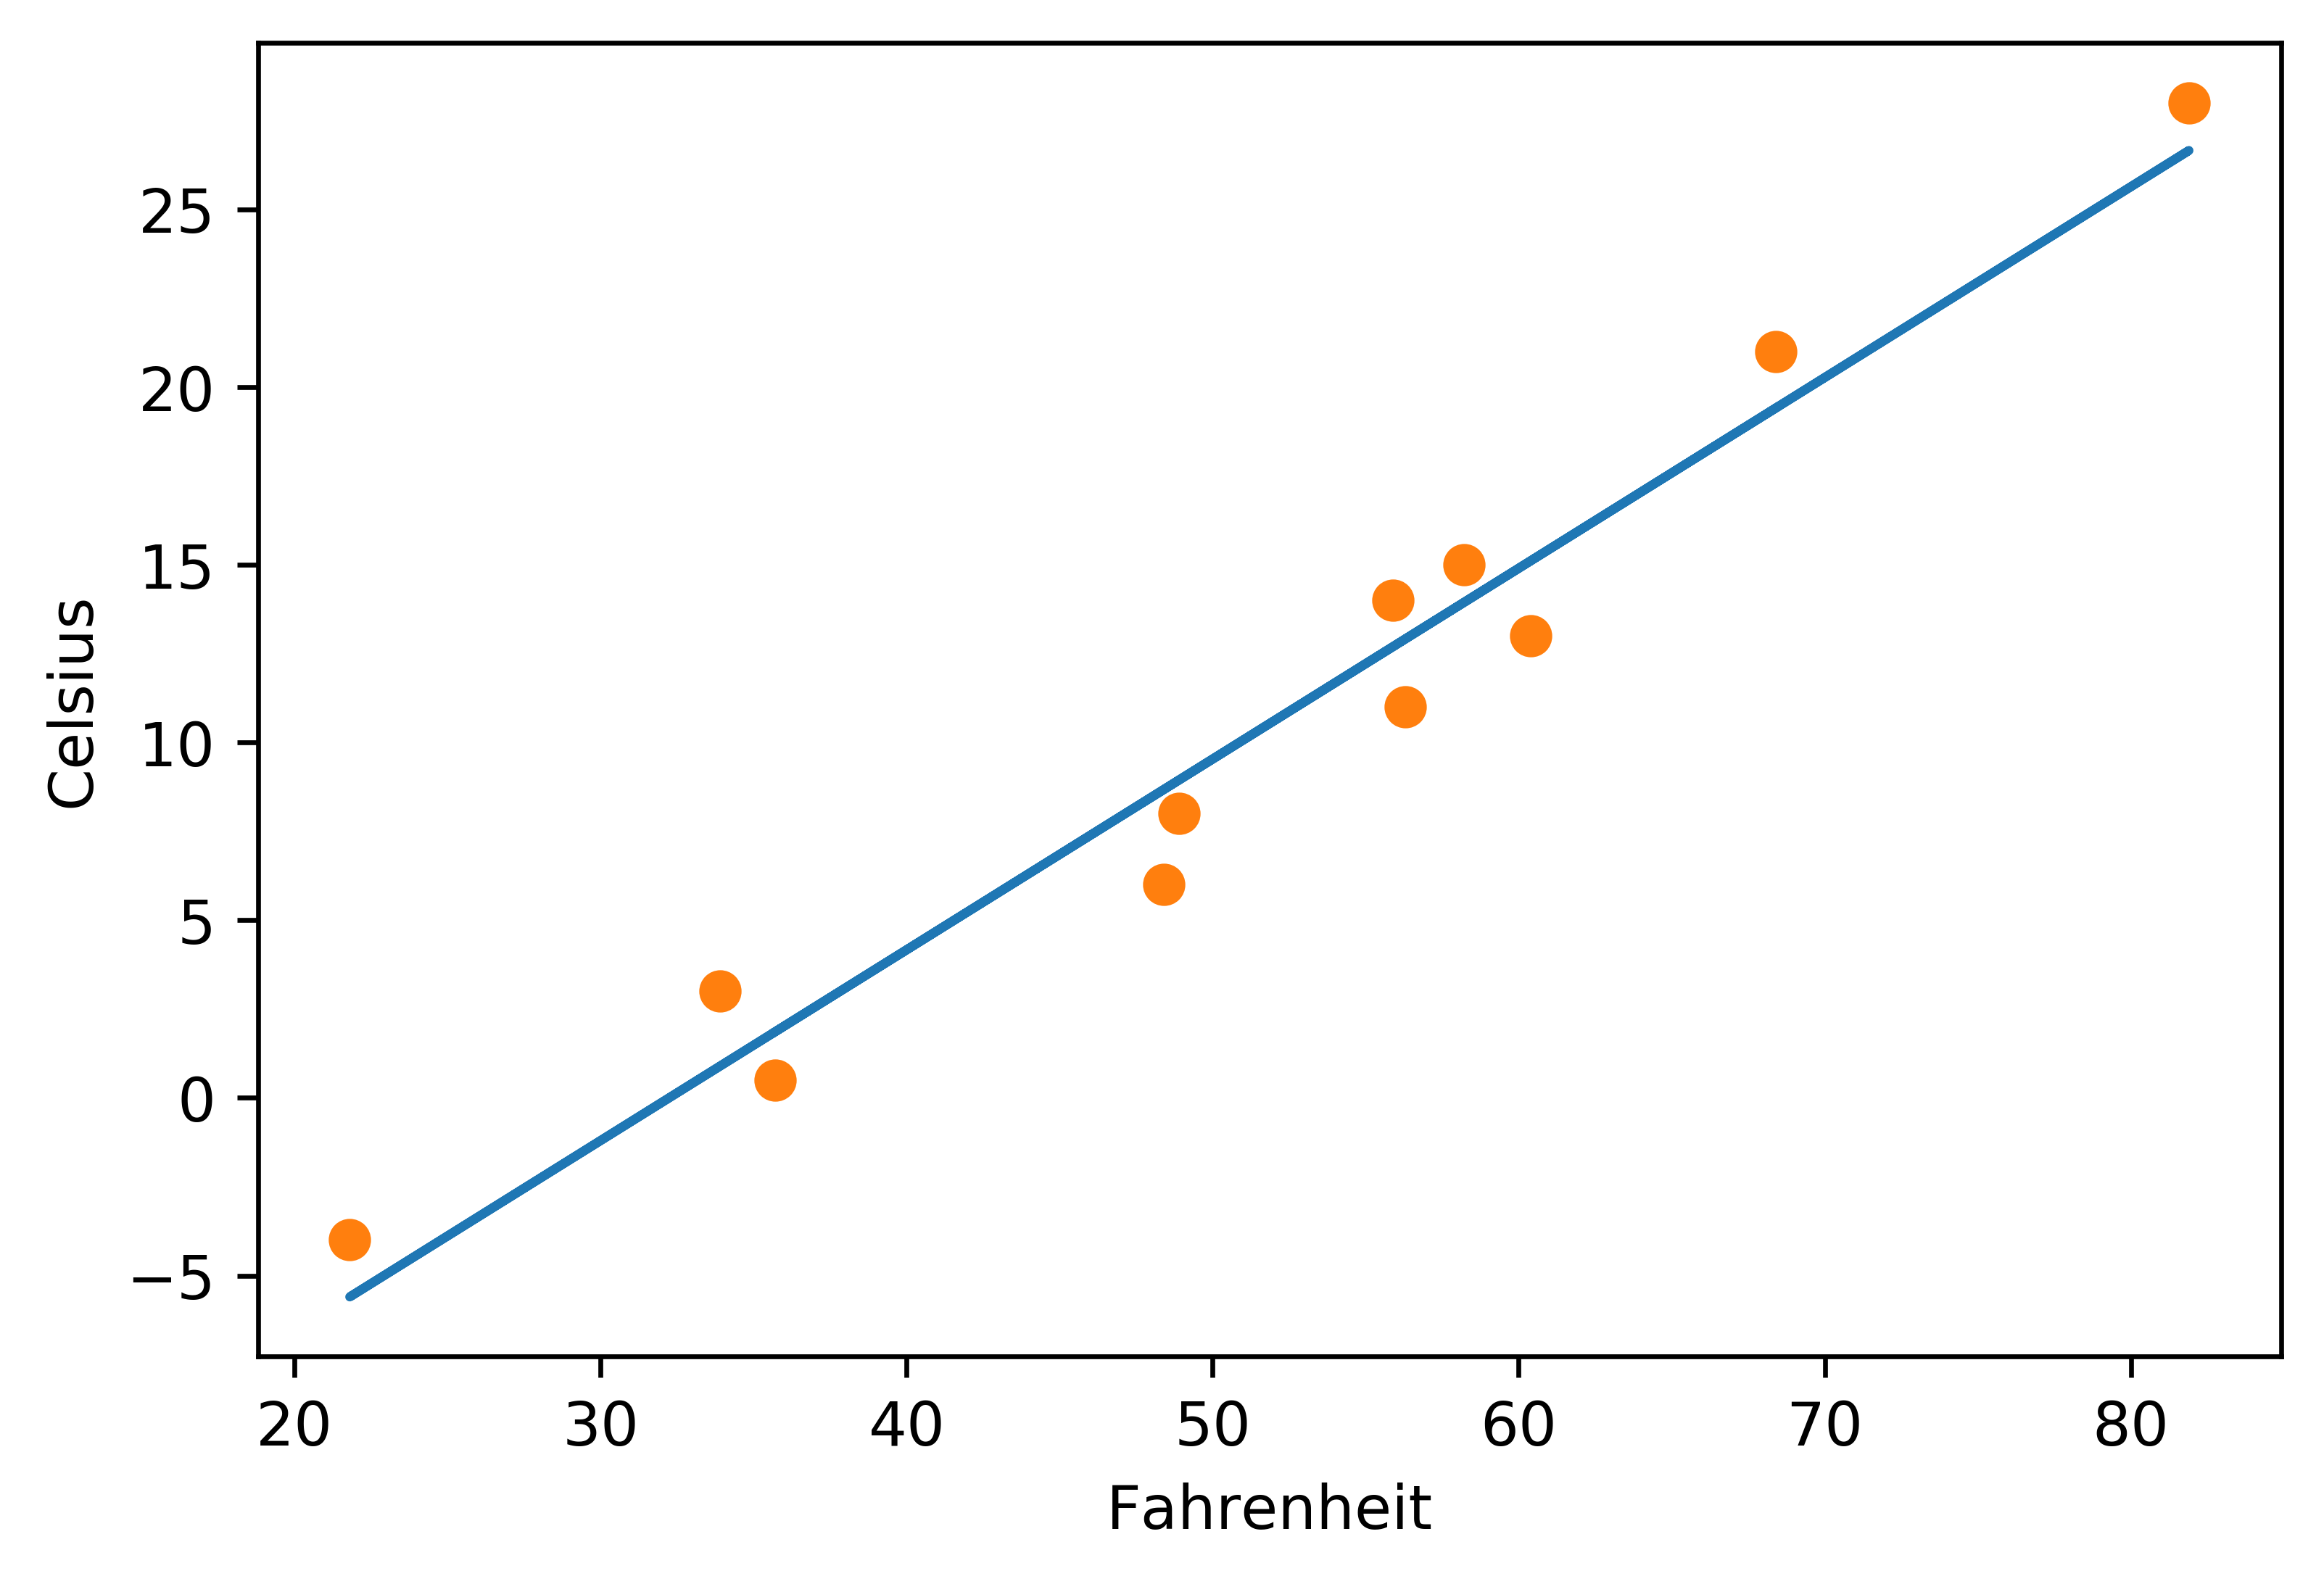

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

# PyTorch Autograd

* Back-propagation
    * calcular la gradiente de una composicion de funciones - el modelo y el _loss_ - con respecto a sus parametros - $w$ y $b$ - propagando derivadas hacia atras usando la regla de la cadena.
* Todas las funciones que deben ser diferenciables.
    * Calcular la gradiente: la razon de cambio del _loss_ con respecto a los parametros

**Que pasa cuando tenemos un modelo con millones de parametros?**
* Funcion diferenciable
* calcular la gradiente
* composicion de varias funciones lineales y no lineales

In [31]:
def model(t_u, w, b):
    return w * t_u + b


def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [32]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

`requires_grad=True`: Le estamos diciendo a PyTorch que mantenga un registro de todos los tensores resultantes de operaciones sobre `params`.

Cualquier tensor que tenga `params` como ancestro va a tener acceso a la cadena de funciones que se llamaron para llegar de `params` a ese tensor.

En caso que estas funciones sean diferenciables (la mayoria de operaciones en PyTorch lo son), el valor de la derivada va a ser automaticamente llenado como el atributo `grad` del tensor `params`.

In [33]:
params.grad is None

True

In [34]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

**dibujo**

* Podemos tener $n$ tensores con `requires_grad=True`
* y cualquier composicion de funciones
* PyTorch calcularia las derivadas del _loss_ a traves de la cadena de esas funciones (grafica computacional)
* **Acumularia** los valores en el atributo `grad` de esos tensores

## Warning

Llamar `backward` hace que las derivadas se **acumulen**. Tenemos que regresar la gradiente a cero explicitamente despues de usarla para actualizar parametros.

In [35]:
if params.grad is not None:
    params.grad.zero_()

In [36]:
def training_loop(model, n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        # grad = grad_fn(t_u, t_c, t_p, w, b)
        loss.backward()
        
        params = (params - learning_rate * params.grad).detach().requires_grad_()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss {loss}")
            
    return params

`params = (params - learning_rate * params.grad).detach().requires_grad_()`

Pensemos en la grafica computacional:
* `p1 = (p0 * lr * p0.grad)`
    * `p0` son los _weights_ del modelo
    * `p0.grad` se calcula de una combinacion de `p0` y nuestra data a traves del _loss function_
* `p2 = (p1 * lr * p1.grad)`
* La grafica computacional de `p1` regresa a `p0` esto representa un problema:
    * Tenemos que mantener `p0` en memoria hasta que termine el training
    * Confunde donde tenemos que asignar el error a traves de back-prop
* En vez, despegamos el nuevo tensor de `params` de la grafica computacional usando `detach()`
* De esta forma `params` pierde la memoria de las operaciones que lo generaron.
* Reanudamos el tracking llamando `requires_grad_()`
* Ahora podemos deshacernos de la memoria mantenida por las versiones viejas de `params` y solo hacemos back-prop con los _weights_ actuales.

In [37]:
training_loop(model=model,
              n_epochs=5000,
              learning_rate=1e-2,
              params=torch.tensor([1.0, 0.0], requires_grad=True), # CLAVE
              t_u = t_un, # Seguimos usando la version normalizada
              t_c = t_c)

Epoch 200, Loss 16.608064651489258
Epoch 400, Loss 9.857802391052246
Epoch 600, Loss 6.438284397125244
Epoch 800, Loss 4.706046104431152
Epoch 1000, Loss 3.828537940979004
Epoch 1200, Loss 3.3840172290802
Epoch 1400, Loss 3.1588308811187744
Epoch 1600, Loss 3.0447585582733154
Epoch 1800, Loss 2.986973524093628
Epoch 2000, Loss 2.9576973915100098
Epoch 2200, Loss 2.9428696632385254
Epoch 2400, Loss 2.935356855392456
Epoch 2600, Loss 2.931553840637207
Epoch 2800, Loss 2.929626226425171
Epoch 3000, Loss 2.9286482334136963
Epoch 3200, Loss 2.9281539916992188
Epoch 3400, Loss 2.927903890609741
Epoch 3600, Loss 2.9277760982513428
Epoch 3800, Loss 2.9277124404907227
Epoch 4000, Loss 2.9276793003082275
Epoch 4200, Loss 2.9276628494262695
Epoch 4400, Loss 2.9276552200317383
Epoch 4600, Loss 2.9276490211486816
Epoch 4800, Loss 2.927647590637207
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

Ya no tenemos que calcular derivadas a mano :)

## Optimizadores

* Hemos estado utilizando gradient descent normal para optimizacion.
* PyTorch abstrae la estrategia de optimizacion
* El modulo `torch` tiene un submodulo `optim`

In [38]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

Todo optmizador:
* toma una lista de parametros (tensores de PyTorch, usualmente con `requires_grad=True`) y mantiene una referencia a ellos.
* luego de que el _loss_ sea calculado con los inputs
* una llamada a `.backward()` provoca que se llene `.grad` en los parametros
* en ese punto, el optimizador puede accesar `.grad` para actualizar los parametros

In [39]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

* SGD = Stochastic Gradient Descent
* Exactamente lo mimsmo que hemos estado haciendo a mano (siempre y cuando el argumento `momentum` este en su valor default de 0.0)
* El termino _stochastic_ viene del hecho que la gradiente normalmente se obitene promediando sobre un subset aleatorio de todos los inputs, llamado _minibatch_.

In [40]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

* El valor de `params` se actualizo cuando llamamos `step`
* El optimizador utilizo los valores en `params.grad` y actualizo los parametros restando `(lr * grad)` de ellos.

**Que se nos olvido hacer arriba?**

In [41]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [42]:
def training_loop(model, n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss {loss}")
            
    return params

In [43]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(model,
              n_epochs=5000,
              optimizer=optimizer,
             params = params, # Es importante que ambos `params` sean el mismo objeto
             t_u = t_un,
             t_c = t_c)

Epoch 200, Loss 16.608064651489258
Epoch 400, Loss 9.857802391052246
Epoch 600, Loss 6.438284397125244
Epoch 800, Loss 4.706046104431152
Epoch 1000, Loss 3.828537940979004
Epoch 1200, Loss 3.3840172290802
Epoch 1400, Loss 3.1588308811187744
Epoch 1600, Loss 3.0447585582733154
Epoch 1800, Loss 2.986973524093628
Epoch 2000, Loss 2.9576973915100098
Epoch 2200, Loss 2.9428696632385254
Epoch 2400, Loss 2.935356855392456
Epoch 2600, Loss 2.931553840637207
Epoch 2800, Loss 2.929626226425171
Epoch 3000, Loss 2.9286482334136963
Epoch 3200, Loss 2.9281539916992188
Epoch 3400, Loss 2.927903890609741
Epoch 3600, Loss 2.9277760982513428
Epoch 3800, Loss 2.9277124404907227
Epoch 4000, Loss 2.9276793003082275
Epoch 4200, Loss 2.9276628494262695
Epoch 4400, Loss 2.9276552200317383
Epoch 4600, Loss 2.9276490211486816
Epoch 4800, Loss 2.927647590637207
Epoch 5000, Loss 2.9276468753814697


tensor([  5.3671, -17.3012], requires_grad=True)

## Adam

In [44]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # Nuevo optimizador

training_loop(model,
              n_epochs=2000,
              optimizer=optimizer,
              params = params,
              t_u = t_u, # Regresamos a usar el t_u original como input
              t_c = t_c)

Epoch 200, Loss 19.08226203918457
Epoch 400, Loss 10.508145332336426
Epoch 600, Loss 5.641381740570068
Epoch 800, Loss 3.6775739192962646
Epoch 1000, Loss 3.0866997241973877
Epoch 1200, Loss 2.9531853199005127
Epoch 1400, Loss 2.9306914806365967
Epoch 1600, Loss 2.927907705307007
Epoch 1800, Loss 2.927661657333374
Epoch 2000, Loss 2.9276459217071533


tensor([  0.5367, -17.3021], requires_grad=True)

## En resumen

* Back-propagation para estimar la gradiente
* autograd
* optimizar los pesos del modelo usando la SGD u otros optimizadores

# Ejercicios

1. Redefinan el model a `w2 * t_u ** 2 + w1 * t_u + b`
    * Que partes del training loop necesitaron cambiar para acomodar el nuevo modelo?
    * Que partes se mantuvieron iguales?
    * El _loss_ resultante es mas alto o bajo despues de entrenamiento?
    * El resultado es mejor o peor?

In [45]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # Temperatura en grados celsios
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # Unidades desconocidas
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [47]:
def model(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u +b


def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [48]:
w1 = torch.ones(1)
w2 = torch.ones(1)
b = torch.zeros(1)

t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [49]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [50]:
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w1 + delta, w2 + delta, b), t_c) -
                        loss_fn(model(t_u, w1 - delta, w2 - delta, b), t_c)) / (2.0 * delta)

learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = (loss_fn(model(t_u, w1, w2, b + delta), t_c) -
                        loss_fn(model(t_u, w1, w2, b - delta), t_c) / (2.0 * delta))

b = b - learning_rate * loss_rate_of_change_b

In [51]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

In [52]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c)
    return dsq_diffs

In [53]:
def dmodel_dw1(t_u, w, b):
    return t_u

def dmodel_dw2(t_u, w, b):
    return t_u**2

def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [54]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dw1 = dloss_fn(t_p, t_c) * dmodel_dw1(t_u, w1, b)
    dloss_dw2 = dloss_fn(t_p, t_c) * dmodel_dw2(t_u, w2, b)
    dloss_db = dloss_fn(t_p, t_c) * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw1.mean(), dloss_dw2.mean(), dloss_db.mean()])

In [86]:
def training_loop(model, n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w1,w2, b = params
        
        t_p = model(t_u, w1, w2, b) # Forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b) # Backward pass
        
        params = params - learning_rate * grad
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}, Loss {loss}")
            if print_params:
                print(f"\tParams: {params}")
                print(f"\tGrad: {grad}")
        
    return params


params = training_loop(model,
              n_epochs = 200,
              learning_rate= 1e-9,
              params = torch.tensor([1.0, 1.0, 0.0]),
              t_u = t_u,
              t_c = t_c)

Epoch 1, Loss 11709471.0
	Params: tensor([ 9.9964e-01,  9.7685e-01, -5.9642e-06])
	Grad: tensor([3.6181e+05, 2.3149e+07, 5.9642e+03])
Epoch 10, Loss 7718672.5
	Params: tensor([ 9.9673e-01,  7.9096e-01, -5.3873e-05])
	Grad: tensor([2.9382e+05, 1.8794e+07, 4.8449e+03])
Epoch 20, Loss 4857803.5
	Params: tensor([ 9.9414e-01,  6.2512e-01, -9.6640e-05])
	Grad: tensor([2.3316e+05, 1.4910e+07, 3.8464e+03])
Epoch 30, Loss 3057321.75
	Params: tensor([ 9.9208e-01,  4.9356e-01, -1.3060e-04])
	Grad: tensor([1.8504e+05, 1.1828e+07, 3.0543e+03])
Epoch 40, Loss 1924192.875
	Params: tensor([ 9.9045e-01,  3.8919e-01, -1.5756e-04])
	Grad: tensor([1.4687e+05, 9.3835e+06, 2.4259e+03])
Epoch 50, Loss 1211061.875
	Params: tensor([ 9.8915e-01,  3.0639e-01, -1.7898e-04])
	Grad: tensor([1.1659e+05, 7.4440e+06, 1.9273e+03])
Epoch 60, Loss 762254.25
	Params: tensor([ 9.8812e-01,  2.4071e-01, -1.9601e-04])
	Grad: tensor([9.2561e+04, 5.9055e+06, 1.5318e+03])
Epoch 70, Loss 479798.40625
	Params: tensor([ 9.8731e-01,

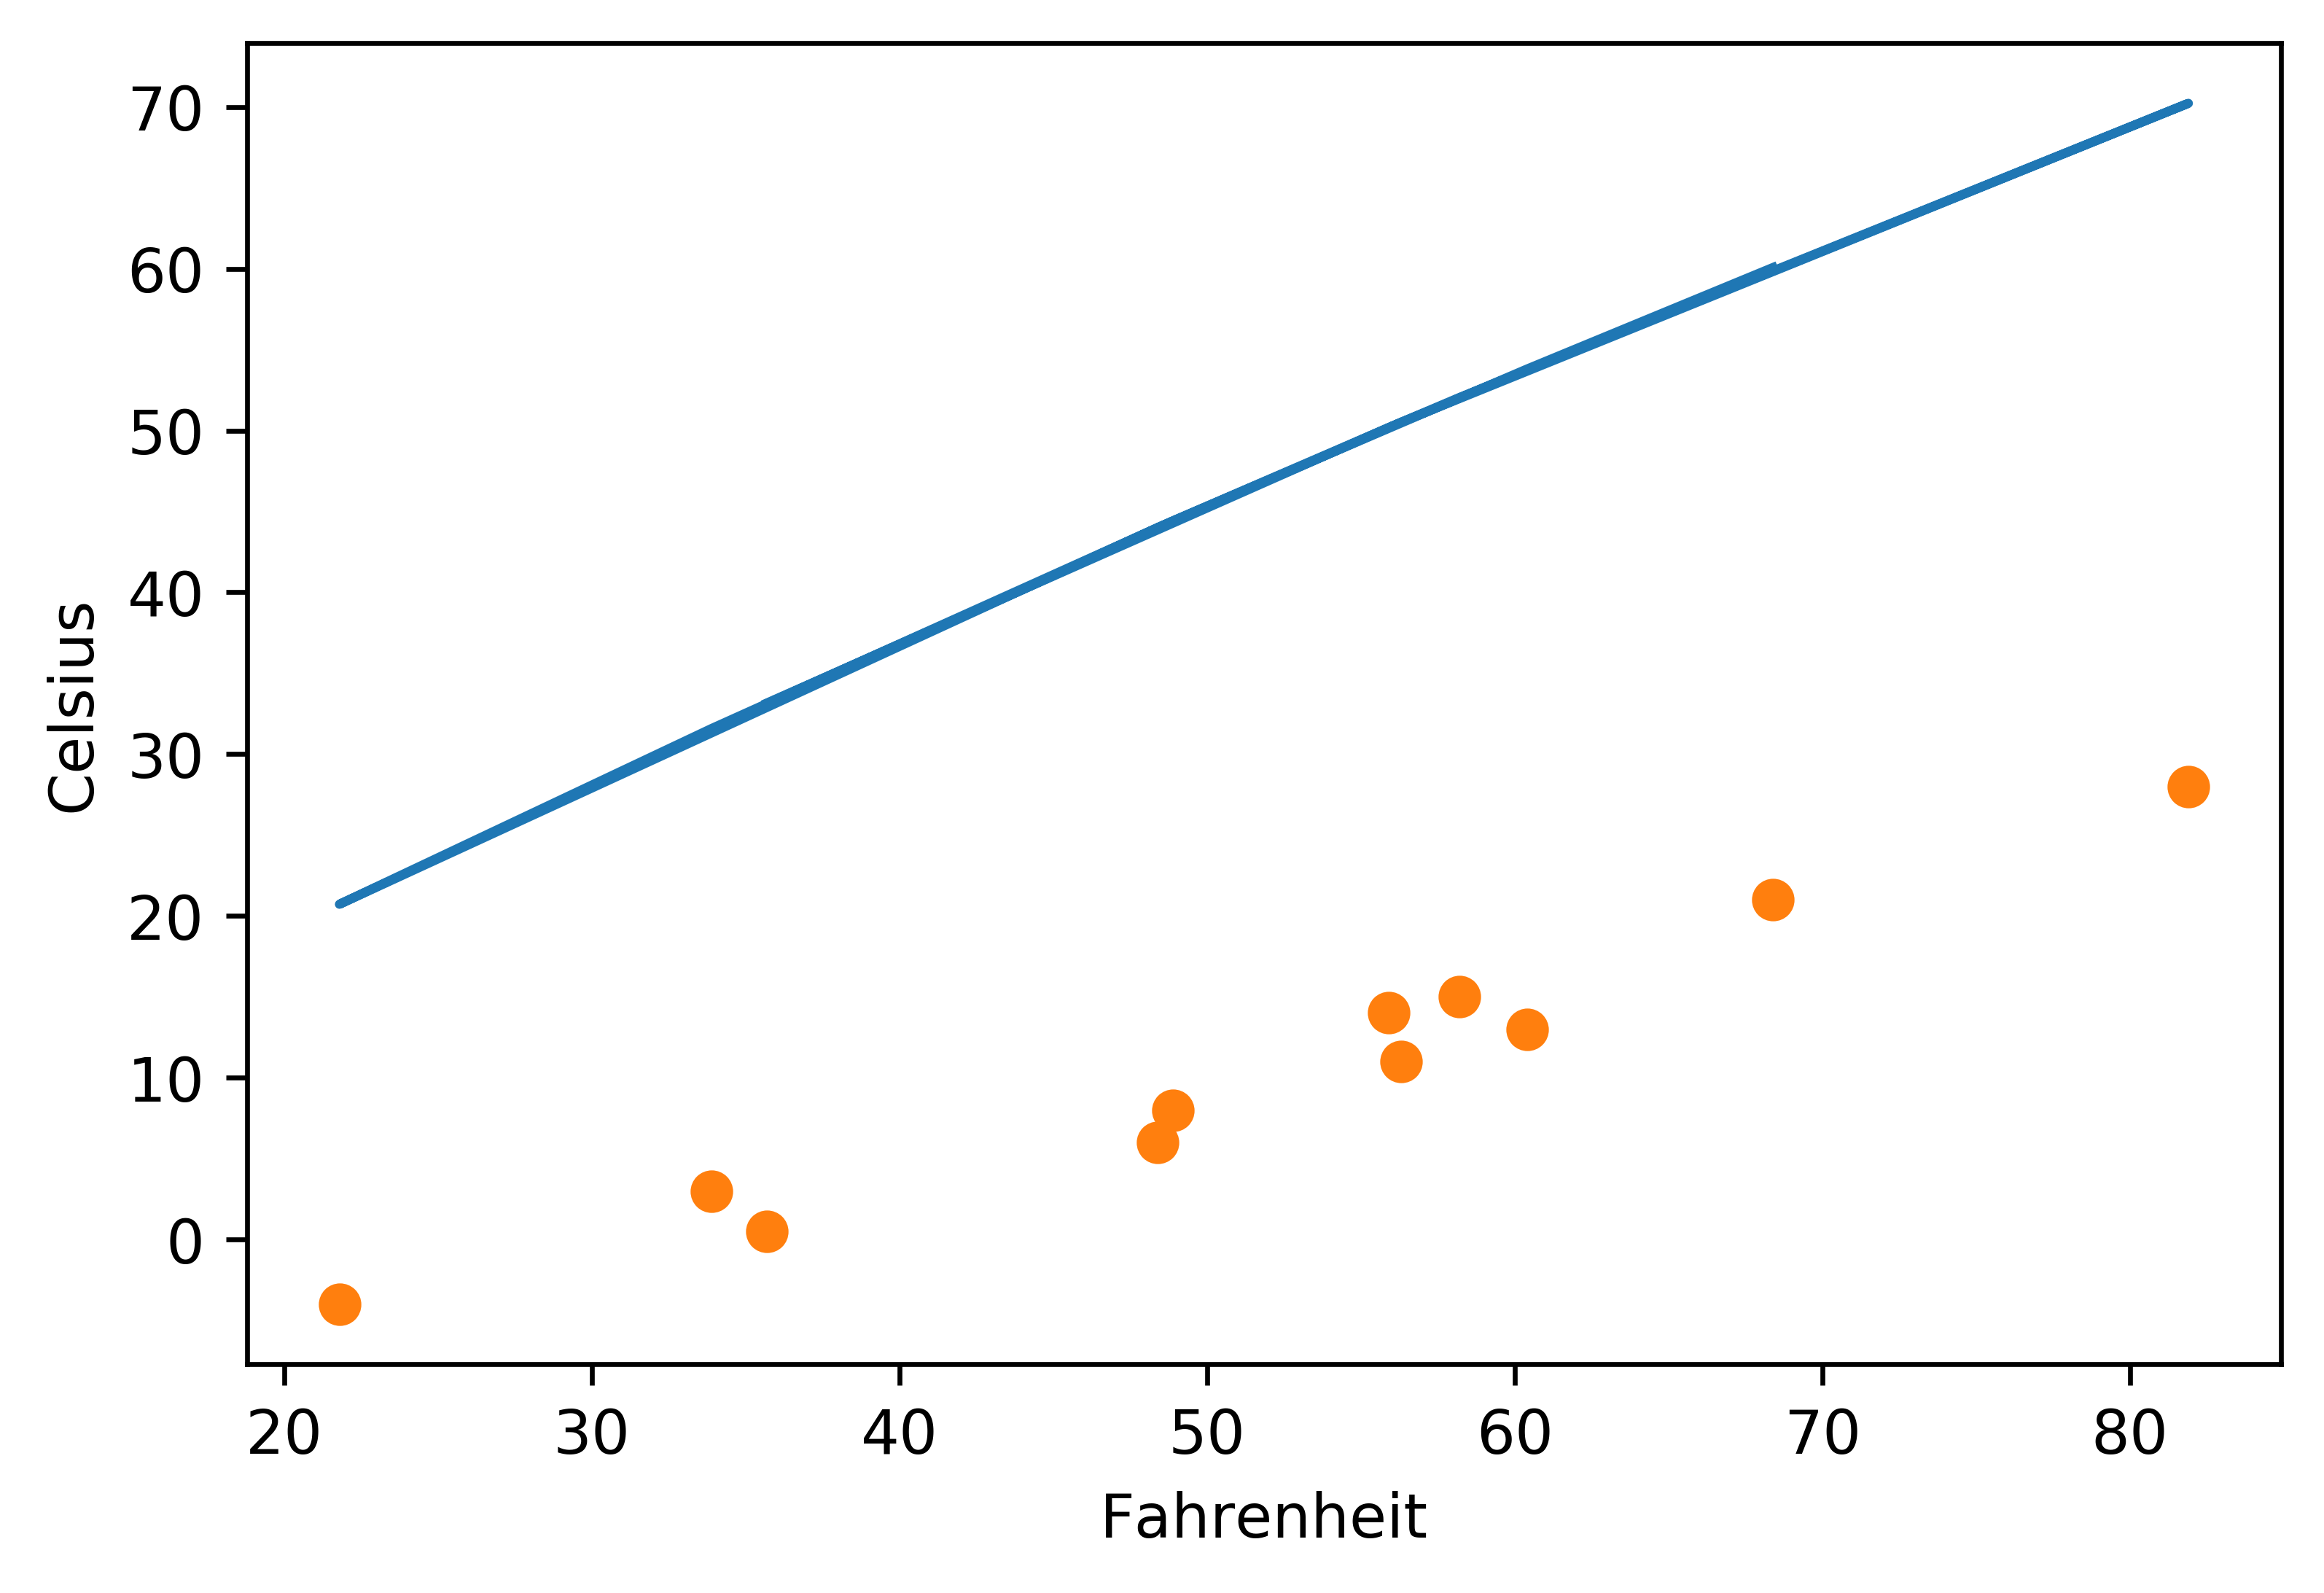

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

t_p = model(t_u, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

In [88]:
t_un = 0.1 * t_u

In [91]:
params = training_loop(model,
              n_epochs = 10000,
              learning_rate= 1e-11,
              params = torch.tensor([1, 0.2, 0.0]),
              t_u = t_un,
              t_c = t_c)

params

Epoch 1, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1232e-11])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 10, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1232e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 20, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.2464e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 30, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.3696e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 40, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.4928e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 50, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.6160e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 60, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -6.7392e-10])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 70, Loss 16.394105911254883
	Params:

	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.6594e-09])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 870, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.7718e-09])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 880, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.8841e-09])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 890, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.9964e-09])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 900, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0109e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 910, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0221e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 920, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0333e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 930, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0

	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1740, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.9544e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1750, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.9656e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1760, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.9768e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1770, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.9880e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1780, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.9993e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1790, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.0105e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 1800, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.0217e-08])
	Grad: tensor([ -6.1554, -9

Epoch 2610, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9315e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2620, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9428e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2630, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9540e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2640, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9652e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2650, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9765e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2660, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9877e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2670, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -2.9989e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 2680, Loss 16.3941059

	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9201e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3500, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9313e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3510, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9426e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3520, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9538e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3530, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9650e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3540, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9763e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3550, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -3.9875e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 3560, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9311e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4400, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9423e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4410, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9536e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4420, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9648e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4430, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9760e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4440, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9873e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4450, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -4.9985e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 4460, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9421e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5300, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9534e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5310, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9646e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5320, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9758e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5330, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9871e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5340, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -5.9983e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5350, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -6.0095e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 5360, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0093e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6250, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0206e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6260, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0318e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6270, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0430e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6280, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0543e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6290, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0655e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6300, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -7.0767e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 6310, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0204e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7150, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0316e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7160, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0428e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7170, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0541e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7180, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0653e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7190, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0765e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7200, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -8.0878e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 7210, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0202e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8040, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0314e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8050, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0426e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8060, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0539e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8070, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0651e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8080, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0763e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8090, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -9.0876e-08])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8100, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0054e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8960, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0065e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8970, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0076e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8980, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0087e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 8990, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0099e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9000, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0110e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9010, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.0121e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9020, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1087e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9880, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1098e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9890, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1110e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9900, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1121e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9910, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1132e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9920, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1143e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9930, Loss 16.394105911254883
	Params: tensor([ 1.0000e+00,  2.0000e-01, -1.1155e-07])
	Grad: tensor([ -6.1554, -91.0309,   1.1232])
Epoch 9940, Loss 16.394105911254883
	Params: tensor([ 1.0000e+0

tensor([ 1.0000e+00,  2.0000e-01, -1.1233e-07])

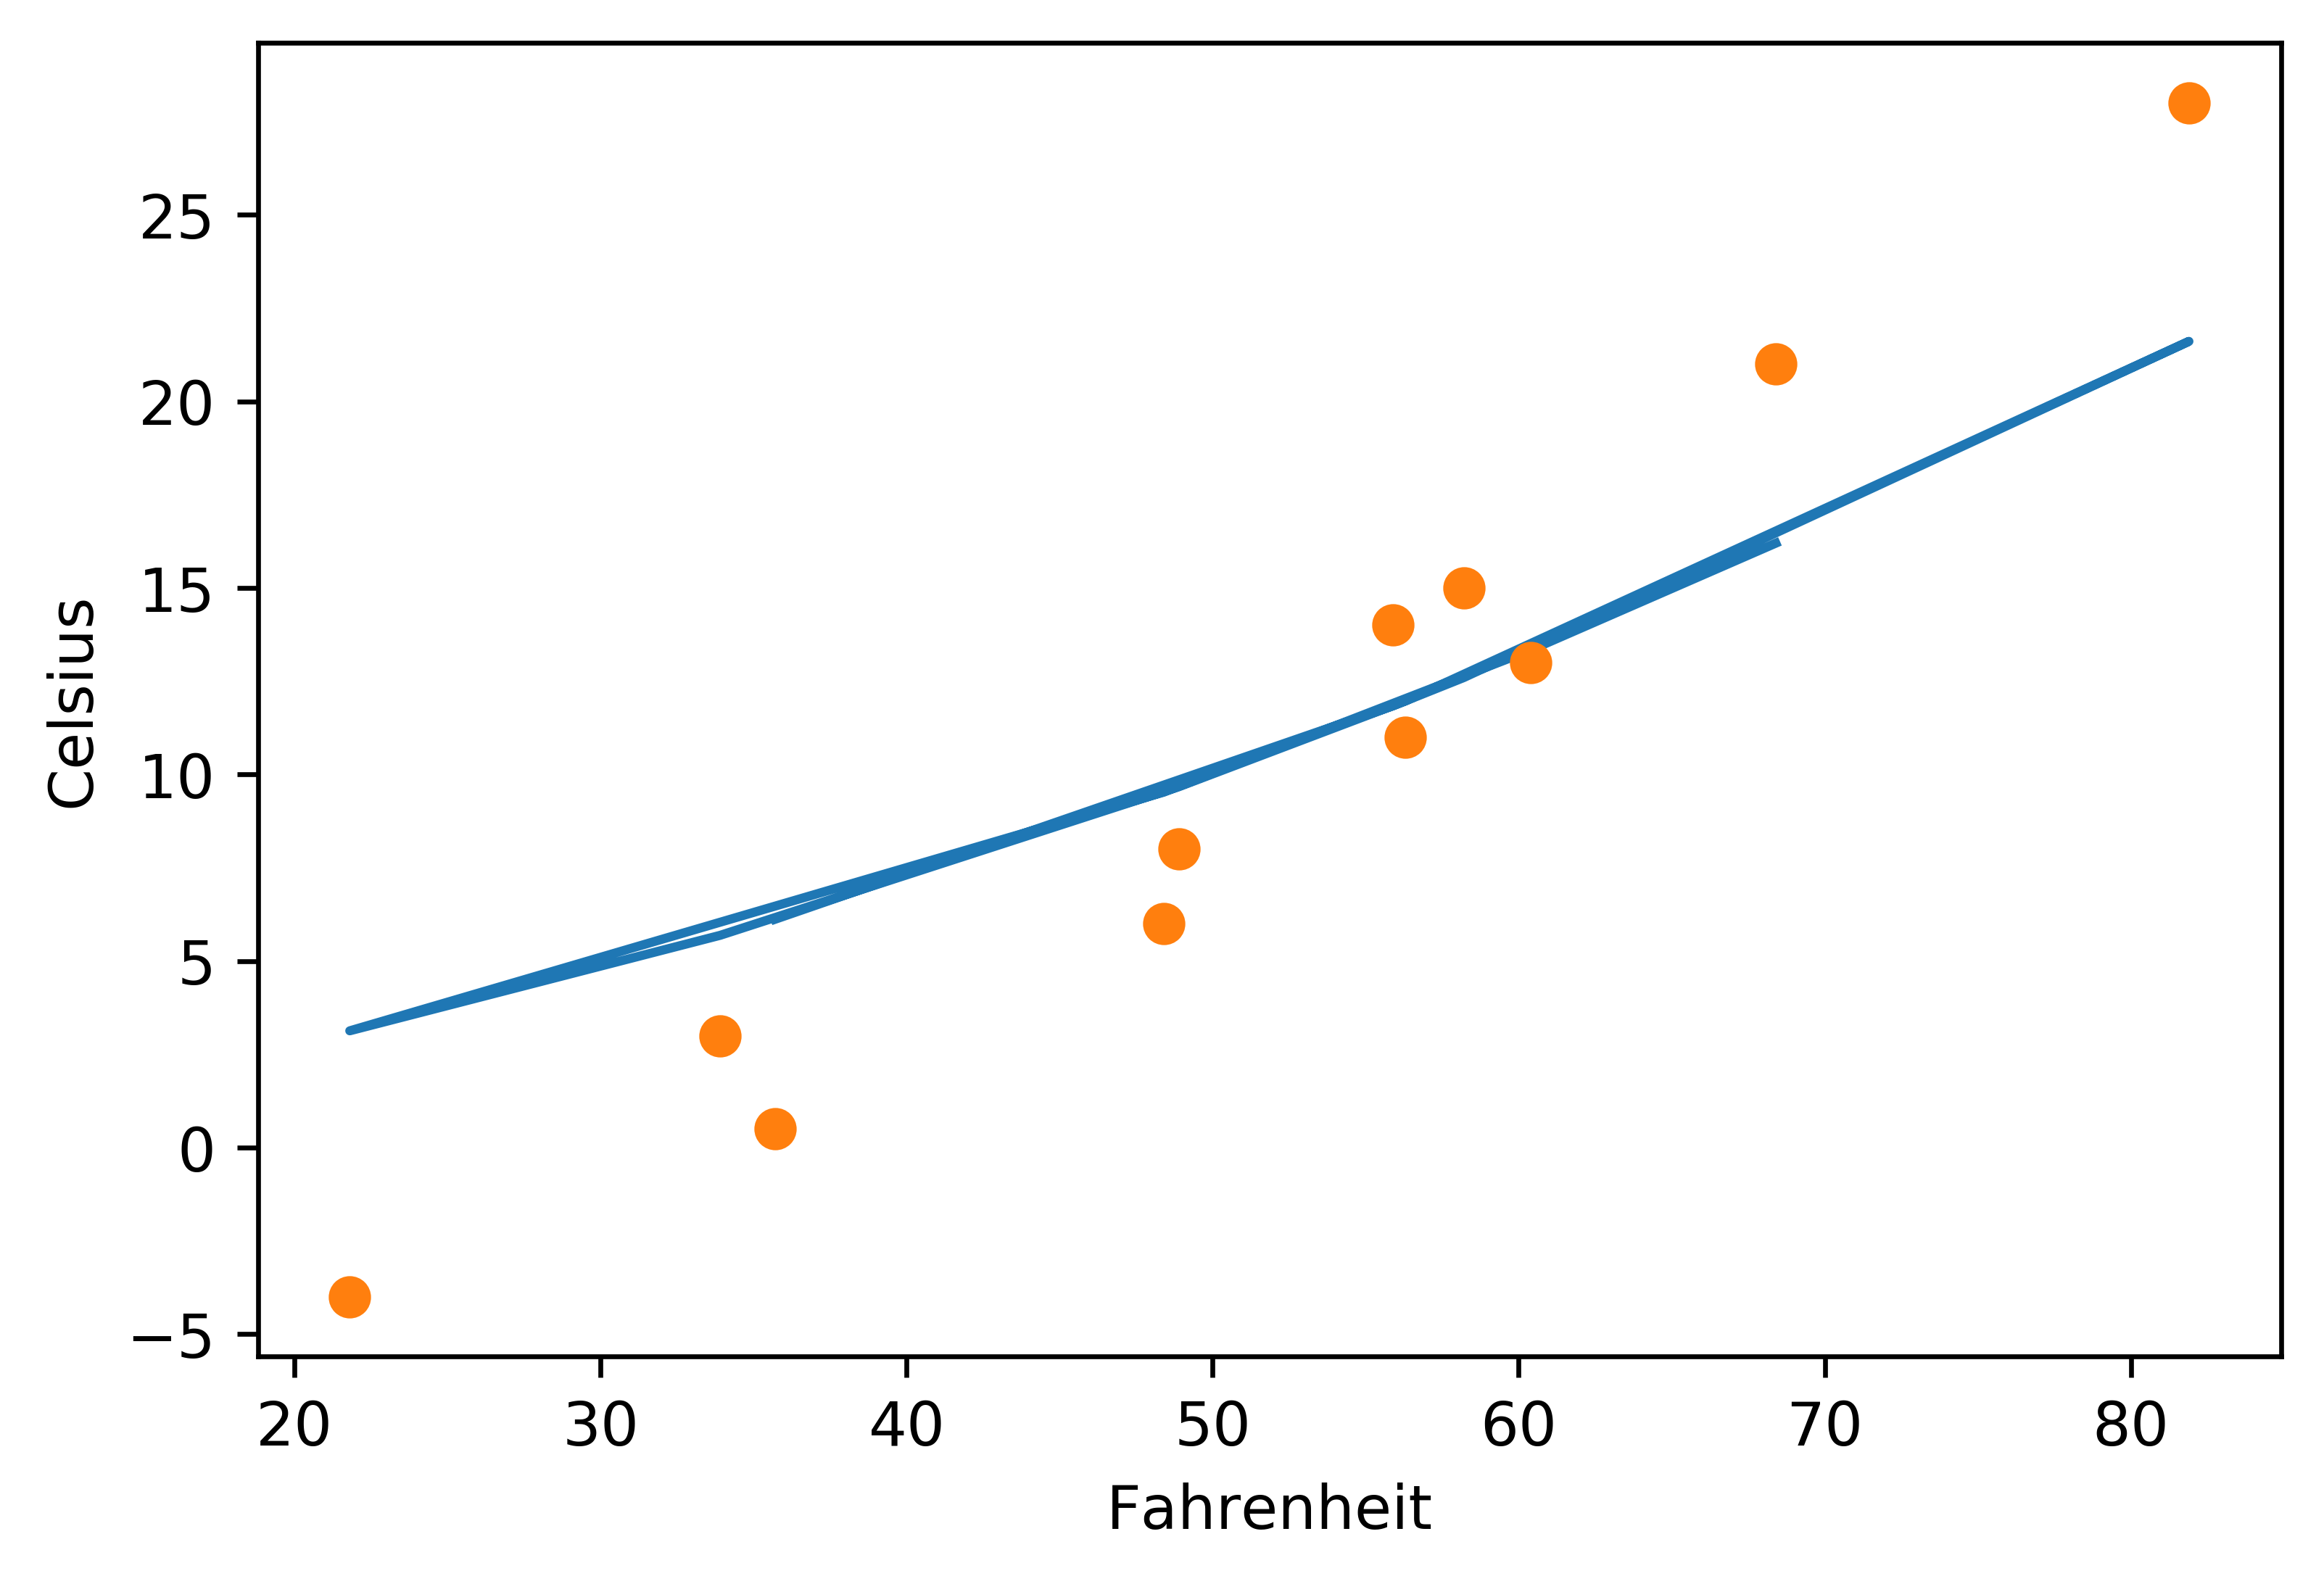

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')